# Workflow

In [2]:
import os
from joblib import dump
from pathlib import Path

import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import numpy as np

from imblearn.over_sampling import SMOTE
import time
from scipy.stats import loguniform, randint
from yellowbrick.model_selection import RFECV
from scipy.stats import loguniform, randint
from sklearn.model_selection import RandomizedSearchCV
import warnings
from imblearn.under_sampling import RandomUnderSampler

In [2]:
start_time = time.time()

In [4]:
# Set up directory
os.chdir("/home/siti/Downloads/New NHS Data")

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('AE_Synthetic_Data_Final_V02.csv')


In [5]:
print(df["LOS_Category"].value_counts())

Short stay    11942983
Long stay       779233
Name: LOS_Category, dtype: int64


In [3]:
results_folder = Path("LogisticRegression_folder/Version 2/Model 4")
results_folder.mkdir(parents=True, exist_ok=True) 

# Feature Engineering

## 1. AE_Arrive_HourOfDay

In [9]:
# Define a function to map the time bands to categories
def categorize_time_band(band):
    if band in ['05-08', '09-12']:
        return 'Morning'
    elif band in ['13-16', '17-20']:
        return 'Evening'
    else:  # '01-04', '21-24'
        return 'Night'

# Apply the function to the Time_band column
df['AE_Arrive_HourOfDay'] = df['AE_Arrive_HourOfDay'].apply(categorize_time_band)

print(df.head())

        IMD_Category Age_Band     Sex AE_Arrive_HourOfDay  AE_Time_Mins  \
0  Most deprived 20%    65-84    Male             Evening           210   
1          20% - 40%      85+  Female             Evening           240   
2          60% - 80%    65-84  Female             Morning           160   
3  Most deprived 20%    65-84    Male             Evening           310   
4  Most deprived 20%    45-64    Male             Evening           210   

    AE_HRG  AE_Num_Diagnoses  AE_Num_Investigations  AE_Num_Treatments  \
0     High                 1                      5                  3   
1      Low                 1                     10                 10   
2  Nothing                 0                      1                  1   
3      Low                 0                      1                  3   
4     High                 4                      4                  4   

  AE_Arrival_Mode ICD10_Chapter_Code    TFC LOS_Category  
0       Not known              XVIII    180  

## 2. Number of Treatments


In [10]:
# Number of Treatments

# low : 0, 1, 2
# Medium : 3, 4
# high = 10,  7,  6,  5,  8,  9

df['AE_Num_Treatments_Cat'] = pd.qcut(df['AE_Num_Treatments'], q=3, labels=["low", "medium", "high"])


proportions = df['AE_Num_Treatments_Cat'].value_counts(normalize=True)

print(proportions)

low       0.459667
medium    0.282128
high      0.258205
Name: AE_Num_Treatments_Cat, dtype: float64


## 3. Number of Investigation

In [11]:
# Number of Investigation

# low : [1, 2, 3, 0]
# Medium : [5, 4, 6]
# high = [10,  8,  7,  9])

df['AE_Num_Investigations_Cat'] = pd.qcut(df['AE_Num_Investigations'], q=3, labels=["low", "medium", "high"])


proportions = df['AE_Num_Investigations_Cat'].value_counts(normalize=True)

print(proportions)

low       0.370985
medium    0.352462
high      0.276553
Name: AE_Num_Investigations_Cat, dtype: float64


## 4. Number of Diagnoses

Given the distribution's skewness, it might make sense to use custom bins:

- 0 as its own bin (e.g., 'none')
- 1 as its own bin (e.g., 'low')
- 2-3 (or 2-4) as a medium range
- 5-10 as a high range

This approach considers the data's natural concentration around 0 and 1 while still differentiating between medium and higher values.


In [12]:
# Number of Investigations

# count    1.272222e+07
# mean     9.066763e-01
# std      7.732276e-01
# min      0.000000e+00
# 25%      1.000000e+00
# 50%      1.000000e+00
# 75%      1.000000e+00
# max      1.000000e+01


def custom_bin(value):
    if value == 0:
        return 'none'
    elif value == 1:
        return 'low'
    elif 1 < value <= 4:
        return 'medium'
    else:
        return 'high'

df['AE_Num_Diagnoses_Cat'] = df['AE_Num_Diagnoses'].apply(custom_bin)

print(df['AE_Num_Diagnoses_Cat'].value_counts(normalize=True))


low       0.646599
none      0.242790
medium    0.106717
high      0.003894
Name: AE_Num_Diagnoses_Cat, dtype: float64


- About half of the patients live Close (0-3 miles) to the provider.
- A little over a quarter live at a Moderate distance (4-7 miles).
- About 17% are Far (8-15 miles).
- And around 6.5% are Very Far (>15 miles).

In [13]:
# Drop the original columns after caetgorizing number of treatments and diagnoses
df2 = df.drop(['AE_Num_Investigations', 'AE_Num_Treatments', 'AE_Num_Diagnoses'], axis=1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12722216 entries, 0 to 12722215
Data columns (total 13 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   IMD_Category               object  
 1   Age_Band                   object  
 2   Sex                        object  
 3   AE_Arrive_HourOfDay        object  
 4   AE_Time_Mins               int64   
 5   AE_HRG                     object  
 6   AE_Arrival_Mode            object  
 7   ICD10_Chapter_Code         object  
 8   TFC                        object  
 9   LOS_Category               object  
 10  AE_Num_Treatments_Cat      category
 11  AE_Num_Investigations_Cat  category
 12  AE_Num_Diagnoses_Cat       object  
dtypes: category(2), int64(1), object(10)
memory usage: 1.1+ GB


In [14]:
# Convert object types to category
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [15]:
data = df2.copy()

# Define the features and target
feature_cols = data.columns[data.columns != 'LOS_Category']
X = data[feature_cols]
y = data['LOS_Category']


# Step 1: Map the Outcome Variable

In [16]:
y = y.map({'Short stay': 1, 'Long stay': 0})

In [17]:
print(y.value_counts())

1    11942983
0      779233
Name: LOS_Category, dtype: int64


# Step 2: Split Data

In [18]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y) 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

**Overall Proportions:**

- **Test set**: 15% of the original dataset
- **Validation set**: 0.1765 * 0.85 = 0.15 or 15% of the original dataset
- **Training set**: 1−0.15−0.15 = 0.7 or 70% of the original dataset

So, by using this two-step splitting, we've achieved a 70-15-15 split for the training, validation, and test datasets, respectively.

# Identify SKEWED VARIABLES

In [20]:
# Identify skewed columns (assuming numeric columns)
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
skewed_features = X_train[numeric_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_features})

# Get the columns with skewness greater than 0.5
skewed_df = skewness[abs(skewness['Skew']) > 0.5]

# Print the skewed columns along with their skewness values
print(skewed_df)


                  Skew
AE_Time_Mins  2.171221


In [17]:
# Apply log transformation to 'AE_Time_Mins' for training data
X_train['AE_Time_Mins'] = np.log1p(X_train['AE_Time_Mins'])

# Apply log transformation to 'AE_Time_Mins' for testing data
X_test['AE_Time_Mins'] = np.log1p(X_test['AE_Time_Mins'])

# Apply log transformation to 'AE_Time_Mins' for validation data
X_val['AE_Time_Mins'] = np.log1p(X_val['AE_Time_Mins'])

# Step 3: One-Hot Encoding 

In [18]:
# Your nominal columns
nominal_columns = ['Sex', 'AE_Arrival_Mode', 'ICD10_Chapter_Code', 'TFC', 'AE_Arrive_HourOfDay']

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=nominal_columns, drop_first=True)
X_val = pd.get_dummies(X_val, columns=nominal_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=nominal_columns, drop_first=True)

# Get all columns in X_train after one-hot encoding
all_columns = X_train.columns

# Ensure X_val has the same columns as X_train
for col in all_columns:
    if col not in X_val.columns:
        X_val[col] = 0

# Ensure X_test has the same columns as X_train
for col in all_columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Reorder columns in X_val and X_test to match X_train's order
X_val = X_val[all_columns]
X_test = X_test[all_columns]


# Step 4: Ordinal Encoding

In [19]:
orders = {
    'IMD_Category': ['Most deprived 20%', '20% - 40%', '40 - 60%', '60% - 80%', 'Least deprived 20%'],
    'Age_Band': ['01-17', '18-24', '25-44', '45-64', '65-84', '85+'],
    'AE_HRG': ['Nothing', 'Low', 'Medium', 'High'],
    'AE_Num_Treatments_Cat': ['low', 'medium', 'high'],
    'AE_Num_Investigations_Cat': ['low', 'medium', 'high'],
    'AE_Num_Diagnoses_Cat': ['none', 'low', 'medium', 'high']}

# Loop through each column and its respective order to encode
for col, order in orders.items():
    ordinal_encoder = OrdinalEncoder(categories=[order])
    X_train[col] = ordinal_encoder.fit_transform(X_train[[col]])
    X_val[col] = ordinal_encoder.transform(X_val[[col]])
    X_test[col] = ordinal_encoder.transform(X_test[[col]])

# Step 5: Undersampling the majority class

In [24]:
# Initialize the random undersampler
rus = RandomUnderSampler(random_state=42)

# Fit and transform the data with the undersampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Counts of each class
print(y_train_resampled.value_counts())

# Proportions of each class
print(y_train_resampled.value_counts(normalize=True) * 100)


0    545444
1    545444
Name: LOS_Category, dtype: int64
0    50.0
1    50.0
Name: LOS_Category, dtype: float64


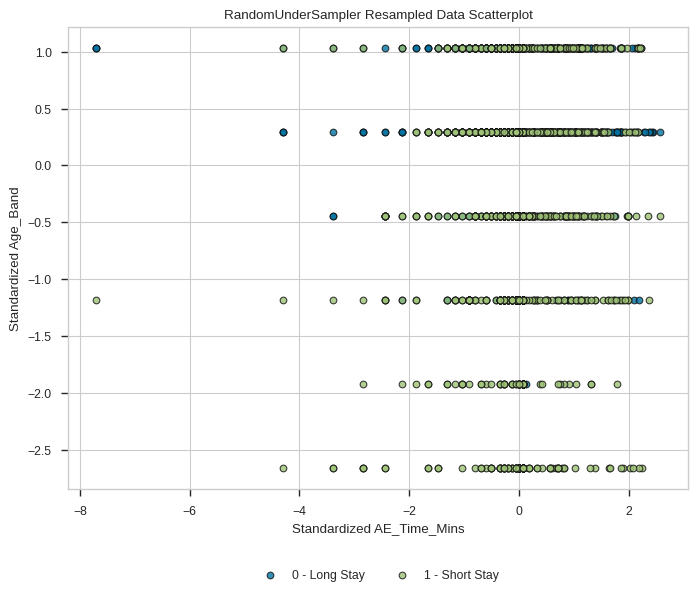

In [25]:

# Setting up the appearance
sns.set_context("paper")

# Create a DataFrame from your resampled data
df_resampled2 = pd.DataFrame(X_train_resampled, columns=['AE_Time_Mins', 'Age_Band'])
df_resampled2['LOS_Category'] = y_train_resampled

# Standardize the features
scaler = StandardScaler()
df_resampled2[['AE_Time_Mins', 'Age_Band']] = scaler.fit_transform(df_resampled2[['AE_Time_Mins', 'Age_Band']])

# Manually select 1000 samples for each class
long_stay_df = df_resampled2[df_resampled2['LOS_Category'] == 0].sample(n=1000, random_state=42)
short_stay_df = df_resampled2[df_resampled2['LOS_Category'] == 1].sample(n=1000, random_state=42)

# Concatenate them to form the final DataFrame to plot
plot_df = pd.concat([long_stay_df, short_stay_df])

# Extract features and labels
X_subset = plot_df[['AE_Time_Mins', 'Age_Band']].values
y_subset = plot_df['LOS_Category'].values

# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

unique_labels = np.unique(y_subset)
for label in unique_labels:
    indices = np.where(y_subset == label)
    ax.scatter(X_subset[indices, 0], X_subset[indices, 1], label=f"{label} - {'Long Stay' if label == 0 else 'Short Stay'}", alpha=0.8, edgecolor='k')

# Place legend at the bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Add x and y axis labels
ax.set_xlabel('Standardized AE_Time_Mins')
ax.set_ylabel('Standardized Age_Band')

# Add title
ax.set_title("RandomUnderSampler Resampled Data Scatterplot")

# Save the plot

plt.savefig(results_folder / "RandomUnderSampler_Resampled_Data_Scatterplot_1000samples.png")

# Show the plot
plt.show()


# Step 6: Standardize Dataset

In [21]:
# Standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 7: RFECV

Perform RFECV on the training set (not including the validation set).

RFECV took 1192.54 seconds.


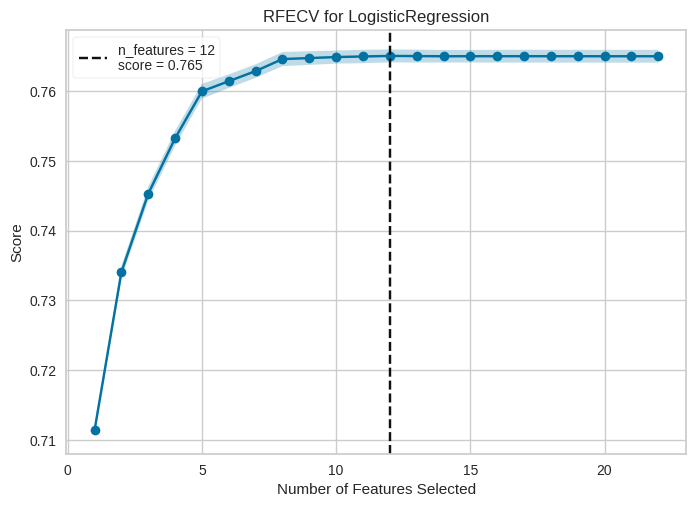

In [22]:
# Record the start time
start_time = time.time()

# Initialize the Logistic Regression estimator 
estimator = LogisticRegression(max_iter=5000, random_state=42) # its not fully utilising CPU so not set up n_jobs = 7

# Use RFECV from Yellowbrick with the settings
visualizer = RFECV(estimator, step=1, cv=5, scoring='roc_auc')

# Fit the visualizer with the scaled resampled training data
visualizer.fit(X_train_scaled, y_train_resampled)

# Set the title, x-label, and y-label before saving the figure
plt.title("RFECV - Feature Selection with Logistic Regression")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score")
plt.savefig(results_folder / "RFECV_LR_V02.png", dpi=300)

# Show the visualizer
visualizer.show(outpath= results_folder / "RFECV.png")

# Record the end time
end_time = time.time()

# Calculate and print the duration
duration = end_time - start_time
print(f"RFECV took {duration:.2f} seconds.")

In [23]:
# Print the features selected by RFECV
feature_names = X_train.columns

# Map the selected features to the original column names
selected_features = [feature for mask, feature in zip(visualizer.support_, feature_names) if mask]

print("Selected Features:", selected_features)

Selected Features: ['Age_Band', 'AE_Arrival_Mode_Not known', 'ICD10_Chapter_Code_Other', 'ICD10_Chapter_Code_X', 'ICD10_Chapter_Code_XI', 'ICD10_Chapter_Code_XIV', 'ICD10_Chapter_Code_XIX', 'ICD10_Chapter_Code_XVIII', 'TFC_180', 'TFC_300', 'TFC_420', 'TFC_OTHER']


# Step 8: Hyperparameter Tuning with Randomized Search CV



In [24]:
# Extract columns from the scaled and resampled training set using the list of selected features
selected_feature_indices = [X_train.columns.get_loc(feature) for feature in selected_features]
X_train_selected_scaled = X_train_scaled[:, selected_feature_indices]


In [ ]:

# Initialize the Logistic Regression estimator 
estimator = LogisticRegression(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'C': loguniform(1e-3, 1e2),
    'penalty': ['l1', 'l2'],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': randint(100, 5000)  # Random integer between 100 and 5000
}

# Record the start time
start_time = time.time()

# Initialize the RandomizedSearchCV
# I set n_iter to 500 earlier, got warnings the line search did not converge, unable to increase this further as laptop crashed
random_search = RandomizedSearchCV(estimator, param_distributions=param_dist, n_iter=50, cv=5, verbose=1, n_jobs=7, random_state=42)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # Execute your RandomizedSearchCV using the entire training set with selected and scaled features
    random_search.fit(X_train_selected_scaled, y_train_resampled)

## Save the cv_results_ to a DataFrame and then to a CSV file
cv_results_df = pd.DataFrame(random_search.cv_results_)
cv_results_df.to_csv(results_folder /'cv_results.csv', index=False)

# Print results
print("Best parameters for LR:", random_search.best_params_)
print("Best ROC-AUC score for LR:", random_search.best_score_)


# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Hyperparameter tuning for LR Tree took {duration:.2f} seconds.")

# Save the model
dump(random_search, results_folder /'random_search_model.joblib')

# Step 9: Train the whole dataset with best hyperparameters


In [26]:
# Extracting selected features for validation, and test sets:

X_val_selected_scaled = X_val_scaled[:, selected_feature_indices]
X_test_selected_scaled = X_test_scaled[:, selected_feature_indices]

In [27]:
# Define the best hyperparameters
best_params = random_search.best_params_


# Record the start time
start_time = time.time()

# Train a logistic regression model using the best hyperparameters on the training set
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_selected_scaled, y_train_resampled)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Training for LR took {duration:.2f} seconds.")

Training for LR took 1.70 seconds.


# Step 10: Predict and Evaluate on Validation Set

In [28]:

# Record the start time
start_time = time.time()

y_val_pred = best_model.predict(X_val_selected_scaled)
y_val_prob = best_model.predict_proba(X_val_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the validation set using multiple metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_prob)  # Note: roc_auc_score uses probability estimates
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

# Print the metrics
print("Validation Metrics:")
print("Accuracy:", val_accuracy)
print("ROC-AUC:", val_roc_auc)
print("F1 Score:", val_f1)
print("Precision:", val_precision)
print("Recall:", val_recall)

# Record the end time
end_time = time.time()
duration = end_time - start_time
print(f"Validating for LR took {duration:.2f} seconds.")

Validation Metrics:
Accuracy: 0.6474934390834155
ROC-AUC: 0.7650561112742374
F1 Score: 0.7731720753103826
Precision: 0.9763732394666013
Recall: 0.6399804213429686
Validating for LR took 1.58 seconds.


# Step 11: Final Model Training and Test Evaluation

Finally, we train on the combined train+validation data and test on the test set.

In [29]:


# Record the start time
start_time = time.time()

# Combine the training and validation sets
X_combined = np.concatenate([X_train_selected_scaled, X_val_selected_scaled], axis=0)
y_combined = np.concatenate([y_train_resampled, y_val], axis=0)

# Train the final model on the combined set
final_model = LogisticRegression(**best_params)
final_model.fit(X_combined, y_combined)

# Record the end time
end_time = time.time()
duration = end_time - start_time

print(f"Training Logistic Regression took {duration:.2f} seconds.")

Training Logistic Regression took 5.08 seconds.


In [30]:
dump(final_model, results_folder / 'final_model_Logistic.joblib')

['LogisticRegression_folder/Version 2/Model 4/final_model_Logistic.joblib']

# Step 12: Predict on test set

In [31]:


# Predict on the test set
y_test_pred = final_model.predict(X_test_selected_scaled)
y_test_prob = final_model.predict_proba(X_test_selected_scaled)[:, 1]  # Probabilities for the positive class

# Evaluate the performance on the test set using multiple metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print the metrics
print("Test Metrics:")
print("Accuracy:", test_accuracy)
print("ROC-AUC:", test_roc_auc)
print("F1 Score:", test_f1)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("Confusion Matrix:")
print(test_conf_matrix)

Test Metrics:
Accuracy: 0.9040157037582015
ROC-AUC: 0.7656840454267216
F1 Score: 0.9489908446962396
Precision: 0.9468739788694042
Recall: 0.9511171968150903
Confusion Matrix:
[[  21286   95599]
 [  87571 1703877]]


# Step 13: Save the metrics

In [32]:
# Save all metrics in a csv file

metrics = {
    "ROC-AUC Test": test_roc_auc ,
    "Accuracy": test_accuracy,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1 Score": test_f1,
    "Confusion Matrix": test_conf_matrix
}

# Convert the metrics to a DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

# Save to CSV
output_path = results_folder / "Model4_Performance_metrics.csv"
metrics_df.to_csv(output_path, index=False)

print(f"Metrics saved to: {output_path}")

Metrics saved to: LogisticRegression_folder/Version 2/Model 4/Model4_Performance_metrics.csv


# ROC-AUC Curve

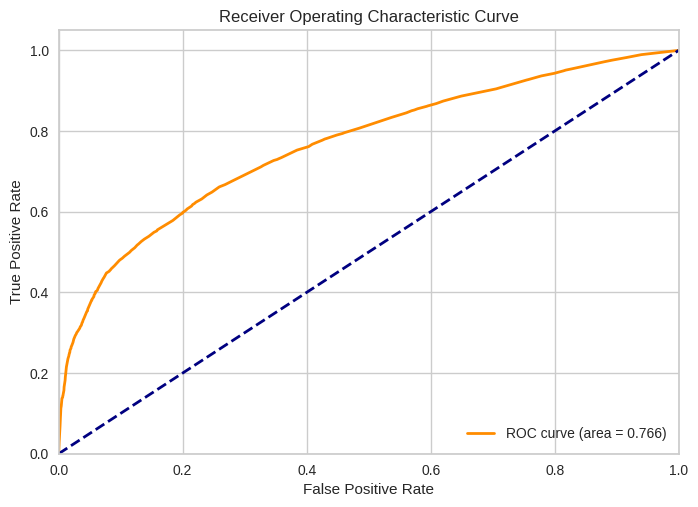

In [33]:


# y_test_prob contains the predicted probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

plt.savefig(results_folder / "ROC_AUC_plot.png", dpi=300)
plt.show()


# Precision-Recall Curve

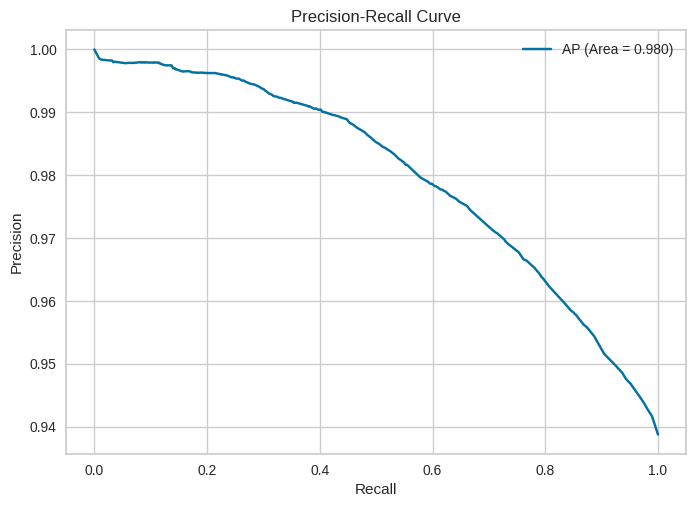

In [34]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
average_precision = average_precision_score(y_test, y_test_prob)

plt.figure()
plt.plot(recall, precision, label='AP (Area = %0.3f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.savefig(results_folder / "Precision_Recall_plot.png", dpi=300)
plt.show()

# Calculate Error

In [35]:
# Predict on training set
y_combined_pred = final_model.predict(X_combined)
combined_accuracy = accuracy_score(y_combined, y_combined_pred)
combined_error = 1 - combined_accuracy

# Predict on validation set
y_val_pred = final_model.predict(X_val_selected_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_error = 1 - val_accuracy

# Predict on test set
y_test_pred = final_model.predict(X_test_selected_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

print(f"Combined Error: {combined_error:.3f}")
print(f"Validation Error: {val_error:.3f}")
print(f"Test Error: {test_error:.3f}")

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Combined Error', 'Validation Error', 'Test Error'],
    'Value': [combined_error, val_error, test_error]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv(results_folder / 'Model_Metrics.csv', index=False)

Combined Error: 0.219
Validation Error: 0.096
Test Error: 0.096


In [36]:
coefficients = final_model.coef_[0]


## Calculate Odds Ratios
The odds ratio for a feature represents how the odds of the positive class change with a one-unit increase in that feature while holding other features constant.

In [37]:
odds_ratios = np.exp(coefficients)

## Rank Features Base don Importance

Rank the features based on the magnitude of their coefficients. The magnitude indicates the importance of the feature, regardless of its direction (positive or negative effect).

In [38]:

sorted_indices = np.argsort(np.abs(coefficients))[::-1]

ranked_features = [feature_names[i] for i in sorted_indices]
ranked_coefficients = [coefficients[i] for i in sorted_indices]
ranked_odds_ratios = [odds_ratios[i] for i in sorted_indices]


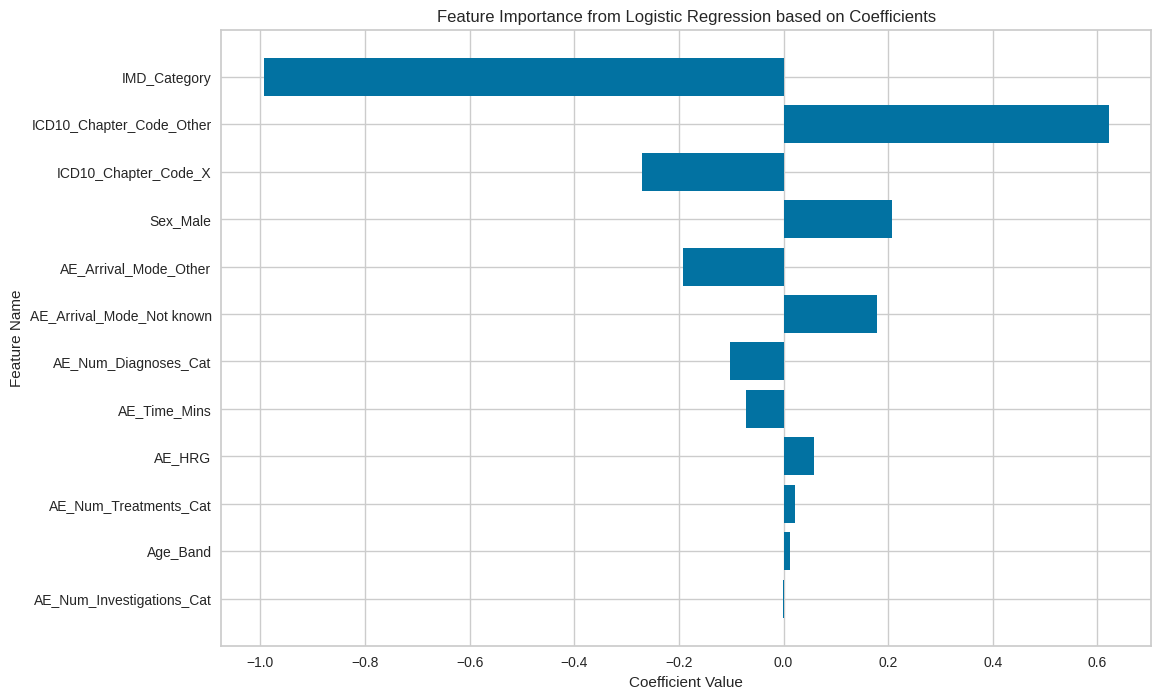

In [39]:
# Visualisation

plt.figure(figsize=(12,8))
plt.barh(ranked_features, ranked_coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance from Logistic Regression based on Coefficients')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig(results_folder / "Feature Importance based on Coefficients_plot.png", dpi=300)
plt.show()

A positive coefficient suggests that as the feature value increases, the log-odds of the response variable being 1 also increase, making the response more likely to be 1. Conversely, a negative coefficient suggests the opposite.

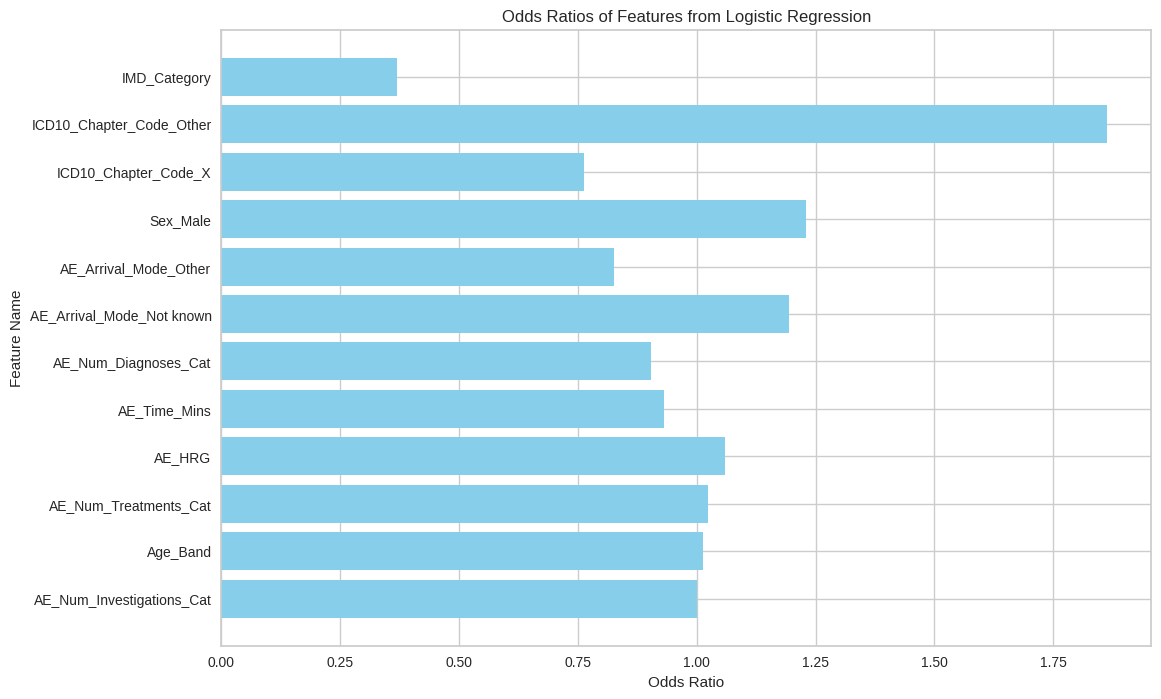

In [40]:
plt.figure(figsize=(12,8))
plt.barh(ranked_features, ranked_odds_ratios, color='skyblue')
plt.xlabel('Odds Ratio')
plt.ylabel('Feature Name')
plt.title('Odds Ratios of Features from Logistic Regression')
plt.gca().invert_yaxis()
plt.savefig(results_folder / "Odds Ratios of Features_plot.png", dpi=300)
plt.show()


In [41]:
# Create a DataFrame
df = pd.DataFrame({
    'Feature': ranked_features,
    'Coefficient': ranked_coefficients,
    'Odds Ratio': ranked_odds_ratios
})

# Save DataFrame to CSV file
df.to_csv(results_folder / 'logistic_regression_coefficients.csv', index=False)

# Significance of Features to Outcome Variable

In [42]:

X_train_selected_scaled_df = pd.DataFrame(X_train_selected_scaled, columns=selected_features)
X_val_selected_scaled_df = pd.DataFrame(X_val_selected_scaled, columns=selected_features)

# Combine the training and validation sets
X_combined = pd.concat([X_train_selected_scaled_df, X_val_selected_scaled_df])

In [43]:
X_with_intercept = sm.add_constant(X_combined)
model = sm.Logit(y_combined, X_with_intercept).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.446920
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              2999539
Model:                          Logit   Df Residuals:                  2999526
Method:                           MLE   Df Model:                           12
Date:                Thu, 07 Sep 2023   Pseudo R-squ.:                  0.1535
Time:                        01:54:41   Log-Likelihood:            -1.3406e+06
converged:                       True   LL-Null:                   -1.5836e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.4365      0.002    740.472      0.000       1.

In [44]:
# Save the summary as a dataframe
# Get the summary as a DataFrame
summary_df = model.summary2().tables[1]

# Save the DataFrame to a CSV file
summary_df.to_csv(results_folder / "Model4_summary.csv")

In [45]:
end_time = time.time()
print(f"Total time to run the notebook: {end_time - start_time:.2f} seconds")


Total time to run the notebook: 17.69 seconds
